## Лабораторная работа № 2 
## Машинное обучение на больших данных с использованием фреймворка Apache Spark и библиотеки SparkML

### Часть 1

В данной части работы рассмотрены:
* подготовка признаков для рашения задачи **линейной регрессии**;
* создание и обучение модели линейной регрессии;
* оценка качества модели.

#### Запуск `Spark`-сессии

Подключаем необходимые библиотеки.

In [1]:
import os
import csv
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, MinMaxScaler, Binarizer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
import seaborn as sns
import matplotlib.pyplot as plt

Сформируем объект конфигурации для `Apache Spark`, указав необходимые параметры.

In [2]:
def create_spark_configuration() -> SparkConf:
    """
    Создает и конфигурирует экземпляр SparkConf для приложения Spark.

    Returns:
        SparkConf: Настроенный экземпляр SparkConf.
    """
    # Получаем имя пользователя
    user_name = os.getenv("USER")
    
    conf = SparkConf()
    conf.setAppName("lab 2 Test")
    conf.setMaster("yarn")
    conf.set("spark.submit.deployMode", "client")
    conf.set("spark.executor.memory", "12g")
    conf.set("spark.executor.cores", "8")
    conf.set("spark.executor.instances", "6")
    conf.set("spark.driver.memory", "4g")
    conf.set("spark.driver.cores", "2")
    conf.set("spark.jars.packages", "org.apache.iceberg:iceberg-spark-runtime-3.5_2.12:1.6.0")
    conf.set("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions")
    conf.set("spark.sql.catalog.spark_catalog", "org.apache.iceberg.spark.SparkCatalog")
    conf.set("spark.sql.catalog.spark_catalog.type", "hadoop")
    conf.set("spark.sql.catalog.spark_catalog.warehouse", f"hdfs:///user/{user_name}/warehouse")
    conf.set("spark.sql.catalog.spark_catalog.io-impl", "org.apache.iceberg.hadoop.HadoopFileIO")

    return conf

Создаём сам объект конфигурации.

In [3]:
conf = create_spark_configuration()

Создаём и выводим на экран сессию `Apache Spark`. В процессе создания сессии происходит подключение к кластеру `Apache Hadoop`, что может занять некоторое время.

In [4]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

:: loading settings :: url = jar:file:/opt/spark-3.5.2-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/user0/.ivy2/cache
The jars for the packages stored in: /home/user0/.ivy2/jars
org.apache.iceberg#iceberg-spark-runtime-3.5_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-08d2ccf1-ed9f-428f-bfa5-4e707eacd72e;1.0
	confs: [default]
	found org.apache.iceberg#iceberg-spark-runtime-3.5_2.12;1.6.0 in central
:: resolution report :: resolve 613ms :: artifacts dl 22ms
	:: modules in use:
	org.apache.iceberg#iceberg-spark-runtime-3.5_2.12;1.6.0 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spa

#### Загрузка датасета

Укажем базу данных, которая была создана в первой лабораторной работе.

In [5]:
database_name = "gysynin_dmitry_database"

Установим созданную базу данных как текущую.

In [6]:
spark.catalog.setCurrentDatabase(database_name)

Прочитаем таблицу с **предобработанным датасетом** и загрузим её в `Spark Dataframe`.

In [7]:
df = spark.table("sobd_lab1_processed_table")

Выведем прочитанную таблицу на экран.

In [8]:
df.show()

+--------+---------------+-------------+----------+------------------+------------+-----------+-----+----------+------------+------------+
|VendorID|passenger_count|trip_distance|RateCodeID|store_and_fwd_flag|payment_type|fare_amount|extra|tip_amount|tolls_amount|total_amount|
+--------+---------------+-------------+----------+------------------+------------+-----------+-----+----------+------------+------------+
|       2|              1|         2.72|         1|             false|           1|       12.5|  0.5|      3.25|         0.0|       17.05|
|       2|              1|         1.59|         1|             false|           1|        7.5|  0.5|       1.6|         0.0|        10.4|
|       2|              1|          0.9|         1|             false|           1|        6.0|  0.5|       1.0|         0.0|         8.3|
|       2|              1|         1.96|         1|             false|           1|        9.5|  0.5|       2.0|         0.0|        12.8|
|       2|              3| 

Вспомним описание столбцов и параметры датасета, проанализированные в первой лабораторной работе.

| Название столбца  | Расшифровка |
| ------------- | ------------- |
| VendorID | Код, указывающий на поставщика услуг TPEP, который предоставил запись. 1 - Creative Mobile Technologies 2- VeriFone Inc. |
| passenger_count | Количество пассажиров |
| trip_distance | Расстояние поездки |
| RateCodeID | Окончательный код тарифа, действующий в конце поездки. 1- Стандартный тариф 2- JFK 3- Ньюарк 4- Нассау или Вестчестер 5- Тариф по договоренности 6- Групповая поездка |
| store_and_fwd_flag | Этот флаг указывает, хранилась ли запись о поездке в памяти автомобиля перед отправкой поставщику, так называемый «store and forward», поскольку автомобиль не имел соединения с сервером. Y = поездка с сохранением и пересылкой N= не поездка с сохранением и пересылкой |
| payment_type | Цифровой код, обозначающий, каким образом пассажир оплатил поездку. 1- Кредитная карта 2- Наличные 3- Без оплаты 4-Спор 5- Неизвестно 6-Анулированная поездка |
| fare_amount | Тариф за время и расстояние, рассчитанный счетчиком. |
| extra | Различные доплаты и надбавки. В настоящее время сюда входят только сборы в размере 0,50 и 1 доллара в час пик и ночные сборы. |
| tip_amount | Сумма чаевых - Это поле автоматически заполняется для чаевых по кредитной карте. Чаевые наличными не учитываются. |
| tolls_amount | Общая сумма всех дорожных сборов, оплаченных в поездке. |
| total_amount | Общая сумма, взимаемая с пассажиров. Не включает денежные чаевые. |

Вспомним схему данных.

In [9]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: float (nullable = true)
 |-- RateCodeID: integer (nullable = true)
 |-- store_and_fwd_flag: boolean (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: float (nullable = true)
 |-- extra: float (nullable = true)
 |-- tip_amount: float (nullable = true)
 |-- tolls_amount: float (nullable = true)
 |-- total_amount: float (nullable = true)



Вычислим количество строк в датафрейме.

In [10]:
df.count()

6036111

#### Постановка задачи линейной регрессии

Для датасета, заданного представленными колонками, требуется построить модель линейной регрессии для оценки **расстояния поездки** по всем остальным признакам. 

Для оценки качества обучения следует использовать метрики $RMSE$ и $R^2$.

#### Подготовка и кодирование признаков

Для корректной работы трансформеров преобразуем столбец `` к типу `DoubleType`.

In [11]:
df = df.withColumn("VendorID", col("VendorID").cast(DoubleType()))
df = df.withColumn("passenger_count", col("passenger_count").cast(DoubleType()))
df = df.withColumn("RateCodeID", col("RateCodeID").cast(DoubleType()))
df = df.withColumn("payment_type", col("payment_type").cast(DoubleType()))


Отделим от датасета некоторую часть объёмом примерно 1000 строк, и сохраним её на диске как локальный `csv`-файл. Он понадобится в следующей лабораторной работе.

In [12]:
def save_sample_to_csv(data: DataFrame, file_path: str, 
                       sample_size: int = 1000) -> DataFrame:
    """
    Сохраняет первые `sample_size` строк из DataFrame в CSV-файл 
    на драйвере и возвращает DataFrame с оставшимися данными.

    Args:
        data (DataFrame): DataFrame, из которого нужно извлечь
            строки.
        file_path (str): Путь для сохранения CSV-файла.
        sample_size (int): Количество строк для сохранения
            (по умолчанию 1000).

    Returns:
        DataFrame: DataFrame с оставшимися данными.
    """
    # Определяем пропорции для разделения
    sample_fraction = sample_size / data.count()
    remaining_fraction = 1 - sample_fraction

    # Разделяем DataFrame на два непересекающихся набора данных
    sample_data, remaining_data = data.randomSplit(
        [sample_fraction, remaining_fraction]
    )

    # Сохраняем извлеченные строки в CSV-файл на драйвере
    try:
        with open(file_path, mode="w", newline="") as file:
            writer = csv.writer(file)

            # Записываем заголовок
            writer.writerow(data.columns)

            # Записываем строки
            for row in sample_data.take(sample_size):
                writer.writerow(row)
        print(f"Файл \"{file_path}\" с данными успешно создан.")

    except Exception as e:
        print(f"Ошибка при записи файла: {e}")

    return remaining_data

Определяем путь для сохранения `csv`-файла.

In [13]:
path = "streaming-data.csv"

df = save_sample_to_csv(data=df, file_path=path, sample_size=1000)

Файл "streaming-data.csv" с данными успешно создан.


Оцениваем, сколько строк в датасете осталось.

In [14]:
df.count()

6035138

Разделим датасет на обучающую и тестовую выборки.

In [15]:
train_df, test_df = df.randomSplit([0.8, 0.2])

In [16]:
print(f"Train dataset size: {train_df.count()}")
print(f"Test  dataset size: {test_df.count()}")

Train dataset size: 4828929


Test  dataset size: 1206209


Остальные признаки сгруппируем по их типу:

* **Категориальные** признаки не содержат большого количества категорий, закодируем их `one-hot`-кодировкой.
* **Бинарные** признаки представлены значениями `true` / `false`, которые могут быть интерпретированы как единица и нуль. Поэтому, в кодировании не нуждаются.
* **Количественные** признаки нужно нормализовать / стандартизировать, перед тем, как передавать их в модель.
* **Бинаризуем** количество пассажиров по порогу 5.

In [17]:
categorical_features = ["VendorID", "RateCodeID", "payment_type"]
binary_features = ["store_and_fwd_flag"]
numeric_features = [
    # "trip_distance", 
    "fare_amount", "extra", "tip_amount", "tolls_amount", "total_amount"]
binarizable_feature = "passenger_count"

Создадим конвейер обработки данных, включающий модель линейной регрессии.

In [18]:
def create_pipeline(categorical_features: list[str], numeric_features: list[str], 
                    binary_features: list[str], 
                    binarized_col: str, 
                    threshold: float, 
                    label_col: str, max_iter: int) -> Pipeline:
    
    # Формируем названия колонок для преобразованных признаков
    indexed_categorical_features = [f"{feature}_index" for feature in categorical_features]
    onehot_categorical_features = [f"{feature}_ohe" for feature in categorical_features]
    
    # Выполняем преобразования данных
    string_indexer = StringIndexer(inputCols=categorical_features,
                                   outputCols=indexed_categorical_features,
                                   handleInvalid="keep")
    onehot_encoder = OneHotEncoder(inputCols=indexed_categorical_features,
                                   outputCols=onehot_categorical_features,
                                   dropLast=True,
                                   handleInvalid="keep")
    vector_num_assembler = VectorAssembler(inputCols=numeric_features,
                                           outputCol="numeric_vector")
    numeric_scaler = MinMaxScaler(inputCol="numeric_vector",
                                   outputCol="numeric_vector_scaled")
    binarizer = Binarizer(inputCol=binarized_col,
                          outputCol="passenger_count_binary",
                          threshold=threshold)
    vector_all_assembler = VectorAssembler(
        inputCols=(onehot_categorical_features + binary_features +
                   ["numeric_vector_scaled", "passenger_count_binary"]),
        outputCol="features"
    )

    # Создаем модель линейной регрессии
    linear_regression = LinearRegression(featuresCol="features",
                                         labelCol=label_col,
                                         predictionCol="prediction",
                                         standardization=False,
                                         maxIter=max_iter)

    # Создаем конвейер
    pipeline = Pipeline(stages=[
        string_indexer, onehot_encoder, vector_num_assembler,
        numeric_scaler, 
        binarizer, 
        vector_all_assembler,
        linear_regression
    ])

    return pipeline

In [19]:
pipeline = create_pipeline(categorical_features=categorical_features,
                           numeric_features=numeric_features,
                           binary_features=binary_features,
                           binarized_col="passenger_count",
                           threshold=5.0,
                           label_col="trip_distance",
                           max_iter=5)

#### Обучение модели

Выполним **подбор гиперпараметров** модели линейной регрессии с помощью кросс-валидации на сетке.

Создаем сетку параметров для кросс-валидации, получив объект `LinearRegression` из конвейера.

In [20]:
param_grid = ParamGridBuilder() \
    .addGrid(pipeline.getStages()[-1].regParam, [0.01, 0.1, 1.0]) \
    .addGrid(pipeline.getStages()[-1].elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

Создаем экземпляр `RegressionEvaluator` для оценки модели.

In [21]:
cv_evaluator = RegressionEvaluator(labelCol="trip_distance",
                                   predictionCol="prediction",
                                   metricName="rmse")

Создаем объект `CrossValidator`.

In [22]:
cross_validator = CrossValidator(estimator=pipeline,
                                 estimatorParamMaps=param_grid,
                                 evaluator=cv_evaluator,
                                 numFolds=5)

Обучаем модель конвейера с использованием кросс-валидации.

In [23]:
cv_model = cross_validator.fit(train_df)

24/11/17 14:16:43 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/11/17 14:19:42 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
24/11/17 14:19:42 WARN Instrumentation: [d24f4bab] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
24/11/17 14:43:35 WARN Instrumentation: [4067fa97] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
24/11/17 15:05:51 WARN Instrumentation: [f700d416] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
24/11/17 15:29:39 WARN Instrumentation: [5f528be1] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
24/11/17 15:51:54 WARN Instrumentation: [af0bb891] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
24/11/17 16:12:46 WARN Instrumentation: [d753fdf2] Cholesky so

Выведем параметры **лучшей** модели, определенной в ходе кросс-валидации.

In [24]:
def get_best_model_params(cv_model: CrossValidatorModel) -> dict[str, float]:
    """
    Получает параметры лучшей модели из объекта CrossValidatorModel.

    Args:
        cv_model (CrossValidatorModel): Объект CrossValidatorModel, 
            содержащий лучшую модель.

    Returns:
        Dict[str, float]: Параметры лучшей модели.
    """
    best_model = cv_model.bestModel
    best_params = {
        "regParam": best_model.stages[-1].getRegParam(),
        "elasticNetParam": best_model.stages[-1].getElasticNetParam(),
        "maxIter": best_model.stages[-1].getMaxIter()
    }
    return best_params

In [25]:
for key, value in get_best_model_params(cv_model=cv_model).items():
    print(f"{key}: {value}")

regParam: 0.01
elasticNetParam: 1.0
maxIter: 5


#### Анализ процесса обучения

Визуализируем изменение ошибки модели в ходе обучения и рассчитаем метрики на обучающем датасете.

In [26]:
def plot_training_summary(cv_model: DataFrame) -> None:
    """
    Отображает графики зависимости значения ошибки от номера итерации на
    обучающей выборке, а также значения метрик RMSE и R^2.

    Args:
        cv_model (DataFrame): Обученная модель с использованием кросс-валидации.
    """
    # Получаем лучшую модель
    best_model = cv_model.bestModel

    # Получаем информацию о процессе обучения
    training_summary = best_model.stages[-1].summary

    # Получаем значения ошибки для каждой итерации
    objective_history = training_summary.objectiveHistory

    # Строим график зависимости значения ошибки от номера итерации
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=range(len(objective_history)), 
                 y=objective_history, 
                 marker='o')
    plt.xlabel('Итерация')
    plt.ylabel('Ошибка')
    plt.title("Зависимость значения функции ошибки от номера итерации")

    # Получаем значения метрик
    rmse = training_summary.rootMeanSquaredError
    r2 = training_summary.r2

    # Добавляем значения метрик на график
    plt.text(0.95, 0.95, f"RMSE: {rmse:.2f}\nR^2: {r2:.2f}",
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(facecolor='white', alpha=0.8), zorder=5)
    plt.grid()

    plt.show()

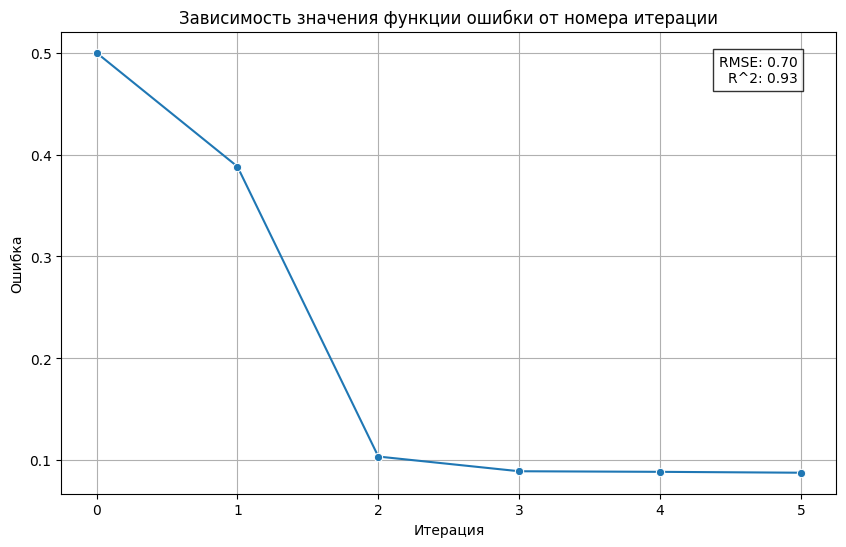

In [27]:
plot_training_summary(cv_model)

#### Проверка обобщающей способности модели

Выполним предсказания на тестовой выборке. 

Перегруппируем колонки датафрейма, переставив столбец с рекомендациями статей в конец, чтобы его значения было удобно сравнивать с предсказанными.

In [28]:
# Получаем датасет предсказаний
test_df_predictions = cv_model.transform(test_df)

# Извлекаем список колонок, устанавливаем цену на последнее место
right_columns_order = test_df_predictions.columns
right_columns_order.remove("trip_distance")
right_columns_order.append("trip_distance")

# Изменяем последовательность колонок и выводим датафрейм
test_df_predictions = test_df_predictions.select(*right_columns_order)
test_df_predictions.show()

+--------+---------------+----------+------------------+------------+-----------+-----+----------+------------+------------+--------------+----------------+------------------+-------------+--------------+----------------+--------------------+---------------------+----------------------+--------------------+--------------------+-------------+
|VendorID|passenger_count|RateCodeID|store_and_fwd_flag|payment_type|fare_amount|extra|tip_amount|tolls_amount|total_amount|VendorID_index|RateCodeID_index|payment_type_index| VendorID_ohe|RateCodeID_ohe|payment_type_ohe|      numeric_vector|numeric_vector_scaled|passenger_count_binary|            features|          prediction|trip_distance|
+--------+---------------+----------+------------------+------------+-----------+-----+----------+------------+------------+--------------+----------------+------------------+-------------+--------------+----------------+--------------------+---------------------+----------------------+--------------------+----

Создадим функцию оценки модели: расчета метрик для некоторого датасета, как правило, тестового.

In [29]:
def evaluate_model(data: DataFrame, metric_name: str) -> float:
    """
    Оценивает модель с использованием указанной метрики.

    Args:
        data (DataFrame): DataFrame, содержащий предсказания и фактические метки.
        metric_name (str): Название метрики для оценки (например, "rmse", "r2").

    Returns:
        float: Значение указанной метрики.
    """
    evaluator = RegressionEvaluator(labelCol="trip_distance", 
                                    predictionCol="prediction", 
                                    metricName=metric_name)
    metric_value = evaluator.evaluate(data)
    return metric_value

Оценим модель на тестовой выборке.

In [30]:
test_rmse = evaluate_model(test_df_predictions, "rmse")
test_r2 = evaluate_model(test_df_predictions, "r2")

print(f"RMSE on test data: {test_rmse:.2f}")
print(f"R^2 on test data: {test_r2:.2f}")

RMSE on test data: 0.69
R^2 on test data: 0.94


Метрики весьма неплохие для линейной модели!

#### Сохранение модели

Зададим директорию студента в `HDFS`, в которой будет сохранена обученная модель.

In [31]:
student_hdfs_folder = "gysynin_dmitry_data"

In [32]:
# Получаем имя пользователя
user_name = os.getenv("USER")

# Путь модели в HDFS
model_hdfs_path = f"hdfs:///user/{user_name}/{student_hdfs_folder}/models/lr-model-4(last)"

# Сохраняем модель конвейера в HDFS
try:
    cv_model.bestModel.save(model_hdfs_path)
    print(f"Модель успешно сохранена в \"{model_hdfs_path}\"")
except Exception as e:
    print(f"Ошибка при сохранении модели: {e}")

Модель успешно сохранена в "hdfs:///user/user0/gysynin_dmitry_data/models/lr-model-4(last)"


Не забываем завершать `Spark`-сессию.

In [33]:
spark.stop()